# What is the Posterior Predictive Distribution?
- is the distribution of possible new data points (y_new) conditioned on the observed data (y) and the posterior distribution of the parameters (θθ):
        - p(y_new∣y)=∫p(y_new∣θ)p(θ∣y)dθ


- where:

    - p(ynew∣θ)p(ynew​∣θ) is the likelihood (data-generating process).
    - p(θ∣y)p(θ∣y) is the posterior distribution of the parameters.
    - y_new is the new or unobserved data.

# Purpose of sample_posterior_predictive:
- Make predictions:
    - Generate predictions for new or unobserved data based on the fitted model.
- Model validation:
    - Compare the posterior predictive distribution to the observed data to check the model's fit.
- Uncertainty quantification:
    - Assess the uncertainty in predictions by generating a distribution of possible outcomes.
# How to Use sample_posterior_predictive:

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y]


Output()

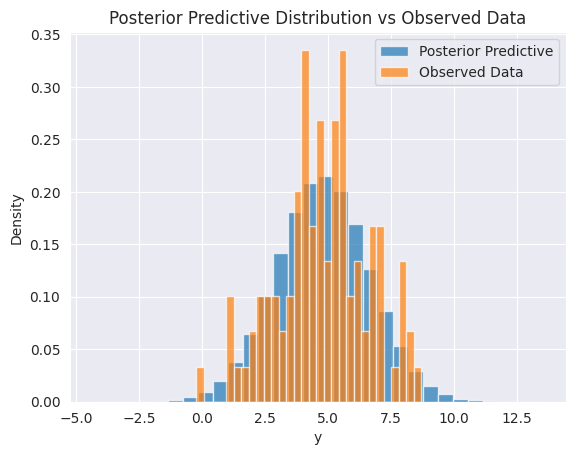

In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# Generate some observed data
np.random.seed(42)
observed_data = np.random.normal(loc=5, scale=2, size=100)

# Define a Bayesian model
with pm.Model() as model:
    # Prior for the mean
    mu = pm.Normal("mu", mu=0, sigma=10)

    # Prior for the standard deviation
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Likelihood (data-generating process)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=observed_data)

    # Sample from the posterior distribution
    trace = pm.sample(1000, tune=1000)

    # Sample from the posterior predictive distribution
    posterior_predictive = pm.sample_posterior_predictive(trace, model=model)

# Extract the posterior predictive samples
posterior_predictive_y = posterior_predictive.posterior_predictive["y"].values

# Plot the posterior predictive distribution
plt.hist(posterior_predictive_y.flatten(), bins=30, density=True, alpha=0.7, label="Posterior Predictive")
plt.hist(observed_data, bins=30, density=True, alpha=0.7, label="Observed Data")
plt.title("Posterior Predictive Distribution vs Observed Data")
plt.xlabel("y")
plt.ylabel("Density")
plt.legend()
plt.show()

# Key Points:
- Observed data: The model is fitted to the observed data (observed=observed_data).
- Posterior samples: The trace object contains samples from the posterior distribution of the parameters.
- Predictive samples: The sample_posterior_predictive function generates samples of new data (y) based on the posterior distribution of the parameters.
- Uncertainty: The posterior predictive distribution captures the uncertainty in both the parameters and the data-generating process.

# When to Use:
- After fitting the model: Use sample_posterior_predictive to generate predictions for new data or validate the model.
- Model checking: Compare the posterior predictive distribution to the observed data to assess the model's fit.
- Decision-making: Use the posterior predictive distribution to make informed decisions under uncertainty.

# Example Use Cases:

- Predictive modeling: Predict future outcomes based on historical data.
- Model validation: Check if the model can reproduce the observed data.
- Sensitivity analysis: Explore how changes in the model affect predictions.
# Prediction on Unseen Data

In [10]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.special import expit as logistic

import pymc as pm
N = 400
true_intercept = 0.2
true_slope = 1.0
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
predictors = rng.normal(size=N)
true_p = logistic(true_intercept + true_slope * predictors)

outcomes = rng.binomial(1, true_p)
outcomes[:10]

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0])

In [7]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.MutableData("pred", predictors, dims="obs_id")
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred), dims="obs_id")

    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes, dims="obs_id")

    idata_2 = pm.sample(1000, tune=2000, return_inferencedata=True, random_seed=rng)
az.summary(idata_2, var_names=["betas"], round_to=2)

/home/asheeshm/workspace/pymc-3rd-party-model/.venv/lib/python3.10/site-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.27,0.11,0.07,0.49,0.0,0.0,3958.05,2869.26,1.0
betas[1],1.19,0.14,0.95,1.48,0.0,0.0,3818.30,2801.46,1.0


In [8]:
predictors_out_of_sample = rng.normal(size=50)
outcomes_out_of_sample = rng.binomial(
    1, logistic(true_intercept + true_slope * predictors_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        idata_2,
        var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

Sampling: []


Output()

In [9]:
preds_out_of_sample = idata_2.predictions_constant_data.sortby("pred")["pred"]
preds_out_of_sample


<xarray.DataArray 'pred' (obs_id: 50)> Size: 400B
array([-1.8235067 , -1.73394626, -1.72587105, -1.41433505, -1.34751955,
       -1.27562804, -1.17437386, -1.17106374, -0.98066116, -0.9762755 ,
       -0.64619765, -0.28881473, -0.2807912 , -0.18802951, -0.18276314,
       -0.14367288, -0.13696541, -0.09322669, -0.068149  , -0.03969434,
        0.01723318,  0.03831253,  0.08144262,  0.12465467,  0.13390892,
        0.15909993,  0.18443769,  0.19143789,  0.21410385,  0.41717265,
        0.55080034,  0.60080874,  0.62190918,  0.62712116,  0.63005716,
        0.68712658,  0.76098326,  0.81698418,  1.05745767,  1.07936013,
        1.15097366,  1.16302293,  1.28127226,  1.37241329,  1.42903446,
        1.46230669,  1.48168015,  1.51712844,  1.6107235 ,  1.70066301])
Coordinates:
  * obs_id   (obs_id) int64 400B 44 34 12 31 6 27 16 38 ... 24 49 25 41 11 23 32